## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star
import time 
%matplotlib inline

from bresenham import bresenham

In [3]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [6]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

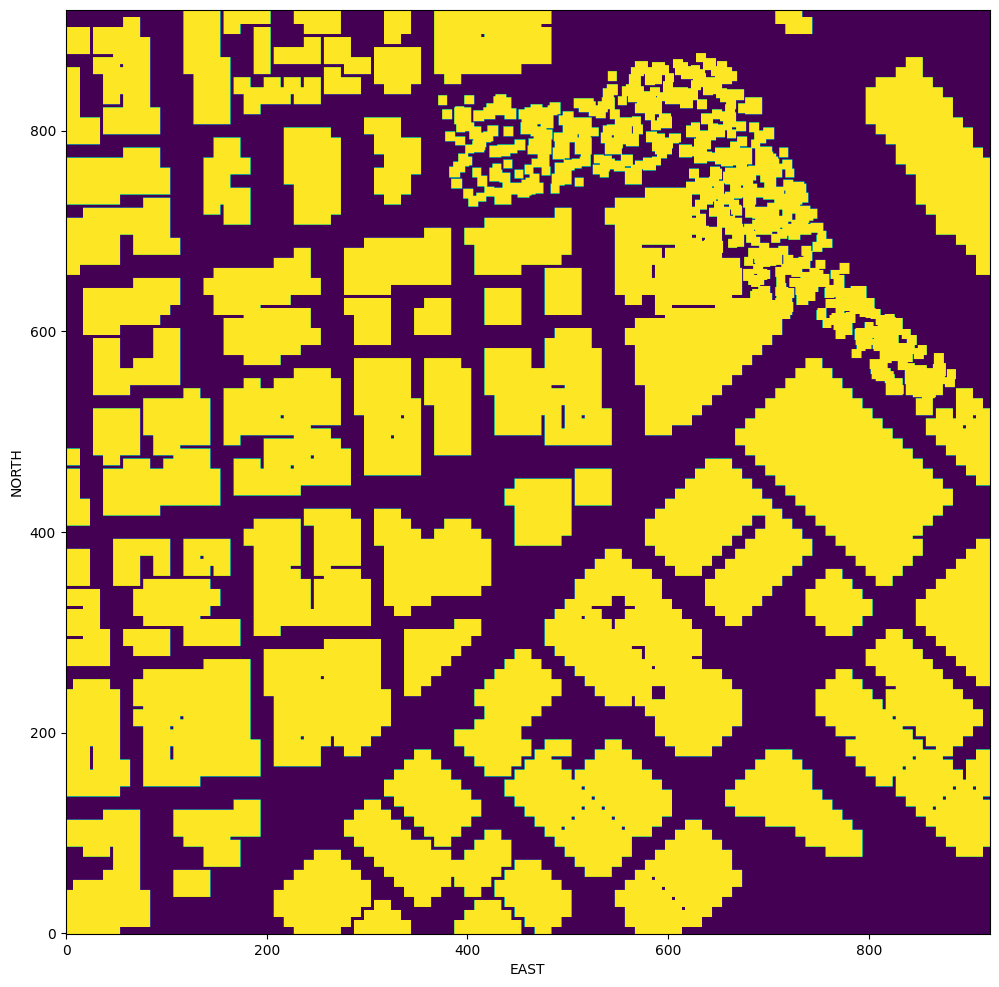

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Write a heuristic function.

In [8]:
def heuristic_func(position, goal_position):
    # TODO: write a heuristic!
    h = 0
    x1, y1 = position
    x2, y2 = goal_position
    # h = math.sqrt((x2 - x1)**2 + (y2 - y1)**2) # Euclidean distance
    h = abs(x2 - x1) + abs(y2 - y1)  # Manhattan distance
    return h

Start and goal coordinates in *(north, east)*.

In [11]:
start_ne = (25,  100)
goal_ne = (750., 370.)

start_ne = (316, 445) 
goal_ne = (612, 888)

Compute the lowest cost path with `a_star`. 

In [14]:
# TODO: use `a_star` to compute the lowest cost path
start_time = time.time()
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")
print(path, cost)

Found a path.
Elapsed time: 1.5990171432495117 seconds
[(316, 445), (316, 446), (316, 447), (316, 448), (316, 449), (316, 450), (316, 451), (316, 452), (316, 453), (316, 454), (316, 455), (316, 456), (316, 457), (316, 458), (316, 459), (316, 460), (316, 461), (316, 462), (316, 463), (316, 464), (316, 465), (316, 466), (316, 467), (316, 468), (316, 469), (316, 470), (316, 471), (316, 472), (316, 473), (316, 474), (316, 475), (316, 476), (316, 477), (316, 478), (316, 479), (316, 480), (316, 481), (316, 482), (316, 483), (316, 484), (316, 485), (316, 486), (317, 486), (318, 486), (319, 486), (320, 486), (321, 486), (322, 486), (323, 486), (324, 486), (324, 487), (324, 488), (324, 489), (324, 490), (324, 491), (324, 492), (324, 493), (324, 494), (324, 495), (324, 496), (325, 496), (326, 496), (327, 496), (328, 496), (329, 496), (330, 496), (331, 496), (332, 496), (333, 496), (334, 496), (334, 497), (334, 498), (334, 499), (334, 500), (334, 501), (334, 502), (334, 503), (334, 504), (334, 50

Let's plot the path!

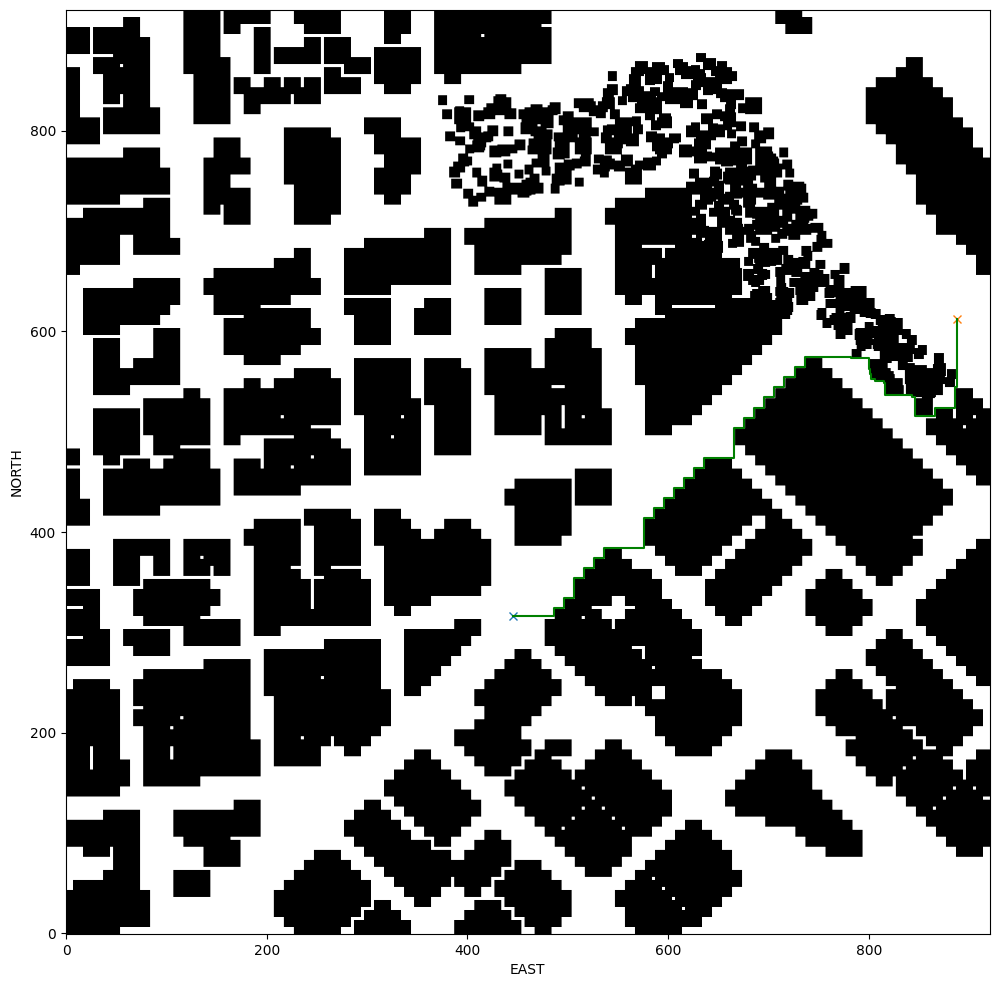

In [15]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [44]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [45]:
def prune_path(path):
    pruned_path = [p for p in path]
    i=0
    while(i < len(pruned_path)-2):
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if (collinearity_check(p1,p2,p3)):
            pruned_path.remove(pruned_path[i+1])
        else:
            i+=1        
    return pruned_path

Prune the path.

In [46]:
pruned_path = prune_path(path)
print(pruned_path)

[(316, 445), (316, 304), (354, 304), (354, 294), (414, 294), (414, 284), (424, 284), (424, 154), (464, 154), (464, 144), (534, 144), (534, 134), (544, 134), (544, 114), (694, 114), (694, 104), (764, 104), (764, 94), (784, 94), (784, 46), (787, 46)]


In [47]:
pruned_path

[(316, 445),
 (316, 304),
 (354, 304),
 (354, 294),
 (414, 294),
 (414, 284),
 (424, 284),
 (424, 154),
 (464, 154),
 (464, 144),
 (534, 144),
 (534, 134),
 (544, 134),
 (544, 114),
 (694, 114),
 (694, 104),
 (764, 104),
 (764, 94),
 (784, 94),
 (784, 46),
 (787, 46)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

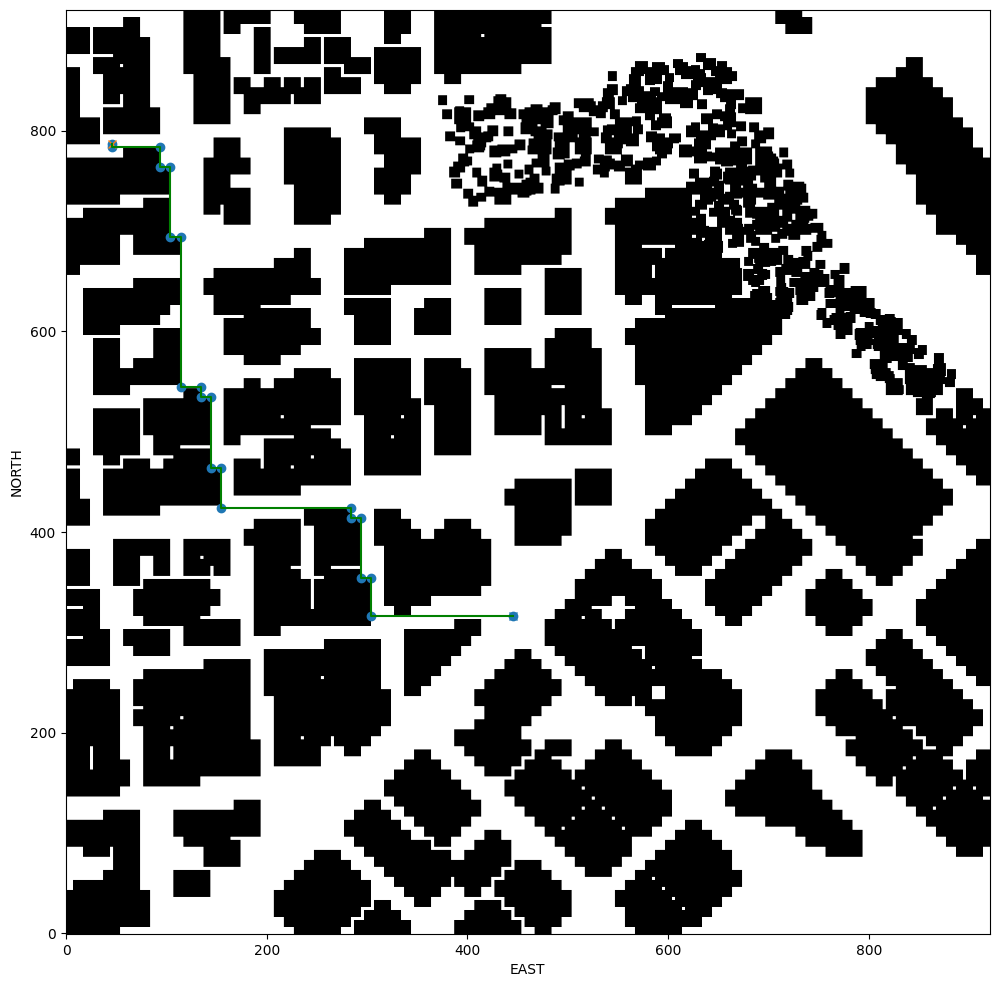

In [48]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)